# ISM 645-Final Project-Predicting 12-month conversion risk (NC/MCI/AD)
## Name: John Daly
## Course: ISM645-Fall 2025
## Instructor: Dr. Shimi Zhou

In [1]:
#Configuration and import libraries
import os, math, json, warnings, datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score, accuracy_score, 
                             brier_score_loss, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

DATA_FILE = Path("C:/Users/jdaly/OneDrive/Desktop/ISM645-Pred Analytics/TADPOLE/TADPOLE_D1_D2.csv")
FIG_DIR = Path("C:/Users/jdaly/OneDrive/Desktop/ISM645-Pred Analytics/TADPOLE/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
RNG_SEED = 42
np.random.seed(RNG_SEED)

print("Figures will be save to:", FIG_DIR.resolve())

Figures will be save to: C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures


## About the TADPOLE Datasets (D1–D3)

TADPOLE defines four standardized datasets derived from the Alzheimer’s Disease Neuroimaging Initiative (ADNI):

| Dataset | Description | Typical Use | Key Trait |
|----------|--------------|--------------|------------|
| **D1** | Historical ADNI training data | Model development | Broad coverage, older data |
| **D2** | Longitudinal prediction set (many visits per subject) | Forecasting progression over time | Rich temporal structure |
| **D3** | Cross-sectional prediction set (single, most recent visit per subject) | Baseline risk prediction | Real-world snapshot scenario |

**Rationale for this approach:**  
D3 represents a baseline snapshot, mirroring real clinical trial conditions where only one visit is available per participant.  
However, the D1_D2 dataset offers a more comprehensive longitudinal record that allows custom label creation — such as the 12-month conversion target used here.  
Using D1_D2 ensures:
- Access to richer historical information,
- The ability to construct outcome labels consistently,
- Flexibility to later derive a D3-style baseline subset if desired.

This approach balances data richness (from D2) with practical interpretability (as in D3).

In [23]:
#Load the TADPOLE data
if not DATA_FILE.exists():
    raise FileNotFoundError(
        f"TADPOLE file not found at {DATA_FILE}. "
        "Please confirm the path and filename of TADPOLE_D1_D2.csv")
    
df_all = pd.read_csv(DATA_FILE)

#Normalizing a few common column names and dtypes
rename_map = {'PTGENDER': 'SEX', 'PTGENDER.x': 'SEX'}
df_all = df_all.rename(columns=rename_map)

if 'EXAMDATE' not in df_all.columns:
    raise KeyError("Expected column 'EXAMDATE' was not found. Please verify the TADPOLE schema.")
df_all['EXAMDATE'] = pd.to_datetime(df_all['EXAMDATE'], errors='coerce')

if 'DX' not in df_all.columns:
    raise KeyError("Expected column 'DX' not found. Please verify the TADPOLE schema.")
    
print("Loaded rows:", len(df_all))
display(df_all.head())

Loaded rows: 12741


,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,EXAMDATE,DX_bl,...,PHASE_UPENNBIOMK9_04_19_17,BATCH_UPENNBIOMK9_04_19_17,KIT_UPENNBIOMK9_04_19_17,STDS_UPENNBIOMK9_04_19_17,RUNDATE_UPENNBIOMK9_04_19_17,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,COMMENT_UPENNBIOMK9_04_19_17,update_stamp_UPENNBIOMK9_04_19_17
0,2,011_S_0002,bl,11,1,1,ADNI1,ADNI1,2005-09-08,CN,...,,,,,,,,,,
1,3,011_S_0003,bl,11,1,0,ADNI1,ADNI1,2005-09-12,AD,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2016-12-14,741.5,239.7,22.83,NaN,2017-04-20 14:39:54.0
2,3,011_S_0003,m06,11,1,0,ADNI1,ADNI1,2006-03-13,AD,...,,,,,,,,,,
3,3,011_S_0003,m12,11,1,0,ADNI1,ADNI1,2006-09-12,AD,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2016-12-14,601.4,251.7,24.18,NaN,2017-04-20 14:39:54.0
4,3,011_S_0003,m24,11,1,0,ADNI1,ADNI1,2007-09-12,AD,...,,,,,,,,,,


## Introduction, Motivation, and Dataset

### Introduction
Alzheimer’s disease (AD) is a progressive neurodegenerative disorder and the leading cause of dementia worldwide, currently affecting over **55 million people**. It gradually erodes memory, reasoning, and independence, placing an enormous emotional and economic burden on patients, caregivers, and healthcare systems.  
Predictive analytics offers a data-driven approach to understanding and forecasting Alzheimer’s progression, allowing earlier interventions, improved care planning, and potentially reduced long-term costs.

### Motivation
**Personal Motivation:**  
This research carries deep personal significance — Alzheimer’s has affected my own family, heightening my awareness of its devastating impact and fueling my interest in solutions that blend empathy with data-driven insight.  

**Professional Motivation:**  
As an engineer drawn to complex, data-rich problems, I find Alzheimer’s research a compelling domain where analytical modeling can truly make a difference. Predictive modeling provides an opportunity to apply machine learning and statistical methods to improve early detection and guide medical decision-making.

**Humanitarian and Economic Rationale:**  
- *Humanitarian Impact:* Early identification of at-risk individuals can preserve quality of life, reduce caregiver strain, and enable personalized treatment strategies.  
- *Economic Impact:* Alzheimer’s disease costs the U.S. over **$300 billion annually**. Predictive models can help optimize healthcare resources by forecasting patient needs and disease trajectories.

### Dataset Overview – The TADPOLE Challenge
The **TADPOLE (The Alzheimer’s Disease Prediction Of Longitudinal Evolution)** dataset was derived from the **Alzheimer’s Disease Neuroimaging Initiative (ADNI)** and designed for forecasting Alzheimer’s progression. It combines:
- **Demographic data:** age, sex, education, and APOE4 genetic status  
- **Clinical data:** baseline and follow-up diagnoses (CN, MCI, AD)  
- **Cognitive scores:** e.g., ADAS-Cog13, MMSE, FAQ  
- **Imaging biomarkers:** hippocampal and ventricular volumes, intracranial volume (ICV)  
- **Molecular biomarkers:** amyloid (AV45), tau, and p-tau levels  

The dataset tracks **thousands of participants** across multiple visits over several years, forming one of the most comprehensive longitudinal resources for modeling Alzheimer’s progression.  

### Why 12-Month Conversion Prediction?
Predicting **12-month conversion from Mild Cognitive Impairment (MCI) to Alzheimer’s Disease (AD)** is a clinically significant task:
- It mirrors the **short-term clinical trial horizon**, where one-year outcomes inform treatment efficacy.  
- It allows physicians and researchers to identify high-risk individuals early, prioritizing those most likely to progress for closer monitoring or therapeutic intervention.  
- It aligns with the TADPOLE challenge’s broader goal — using multimodal longitudinal data to predict disease progression.

In [24]:
#Normalize diagnosis labels 
def normalize_dx(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().upper()
    if any(k in s for k in ["AD", "ALZHEIMER", "DEMENTIA"]):
        return "AD"
    if "MCI" in s:  # includes MCI, EMCI, LMCI, MCIc, MCIu
        return "MCI"
    if s in {"CN", "NL", "NORMAL", "CTL"}:
        return "CN"
    return s

df_all["DX_NORM"] = df_all["DX"].apply(normalize_dx)
df_all[["DX", "DX_NORM"]].head()

,DX,DX_NORM
0,NL,CN
1,Dementia,AD
2,Dementia,AD
3,Dementia,AD
4,Dementia,AD


In [44]:
#Baseline & 12‑Month Label

USE_LAST_NONAD_BASELINE = True     
LIMIT_BASELINE_TO_MCI = True       # Restricts baselines to last MCI visit (yields more realistic positives)
WINDOW_DAYS = 720                  # allow visit jitter beyond 365 days

def normalize_dx(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().upper()
    if ("ALZ" in s) or ("DEMENTIA" in s) or s == "AD":
        return "AD"
    if "MCI" in s:  # MCI, EMCI, LMCI, MCIc, MCIu
        return "MCI"
    if s in {"CN", "NL", "NORMAL", "CTL"}:
        return "CN"
    return s

if "DX_NORM" not in df_all.columns:
    df_all["DX_NORM"] = df_all["DX"].apply(normalize_dx)

#Build ALL non-AD visits as candidate baselines (rolling window)
def first_ad_after_dates(df_sorted):
    """Map RID -> earliest AD date overall."""
    ad_first = (
        df_sorted.loc[df_sorted["DX_NORM"] == "AD"]
        .groupby("RID", as_index=False)["EXAMDATE"].min()
        .rename(columns={"EXAMDATE": "FIRST_AD_DATE"})
    )
    return ad_first

def build_rolling_baselines(df_all, feature_cols=None, windows=(365, 450, 540, 720, 1080, 1460)):
    """
    Returns (df_rw, chosen_window) where df_rw has multiple baselines per RID (every non-AD visit),
    and convert_within_12m computed for the first window that yields at least one positive.
    """
    #sort and keep necessary cols
    req = ["RID", "EXAMDATE", "DX_NORM"]
    df_sorted = df_all.dropna(subset=["EXAMDATE", "DX_NORM"]).sort_values(["RID", "EXAMDATE"]).copy()

    if feature_cols is None:
        candidate_feats = [
            "DX", "AGE", "SEX", "APOE4", "AV45", "TAU", "PTAU", "Hippocampus", "ADAS13"
        ]
        feature_cols = [c for c in df_all.columns if any(k.lower() in c.lower() for k in candidate_feats)]

    keep_cols = list(dict.fromkeys(req + feature_cols))  # unique order
    dfk = df_sorted[[c for c in keep_cols if c in df_sorted.columns]].copy()

    #candidate baselines = all non-AD visits
    cand = dfk[dfk["DX_NORM"] != "AD"].copy()

    #prefix baseline columns
    rename_map = {c: f"BASE_{c}" for c in cand.columns if c not in ["RID"]}
    base_df = cand.rename(columns=rename_map)

    #merge FIRST_AD_DATE per RID
    ad_first = first_ad_after_dates(df_sorted)
    df_rw = base_df.merge(ad_first, on="RID", how="left")

    #compute label for progressively larger windows until we get positives
    chosen_window = None
    for w in windows:
        lbl = (
            df_rw["FIRST_AD_DATE"].notna()
            & (df_rw["FIRST_AD_DATE"] > df_rw["BASE_EXAMDATE"])
            & ((df_rw["FIRST_AD_DATE"] - df_rw["BASE_EXAMDATE"]).dt.days <= w)
        ).astype(int)
        vc = lbl.value_counts(dropna=False).to_dict()
        print(f"Window {w}d -> counts {vc}")
        if vc.get(1, 0) > 0 and vc.get(0, 0) > 0:
            df_rw["convert_within_12m"] = lbl
            chosen_window = w
            break

    if chosen_window is None:
        #still keep labels (all 0) using the largest window for transparency
        w = windows[-1]
        df_rw["convert_within_12m"] = (
            df_rw["FIRST_AD_DATE"].notna()
            & (df_rw["FIRST_AD_DATE"] > df_rw["BASE_EXAMDATE"])
            & ((df_rw["FIRST_AD_DATE"] - df_rw["BASE_EXAMDATE"]).dt.days <= w)
        ).astype(int)
        print("No positives found even at max window. Labels remain all zeros.")

    final_keep = [
        "RID", "BASE_EXAMDATE", "convert_within_12m",
        "BASE_DX", "BASE_AGE", "BASE_SEX", "BASE_APOE4",
        "BASE_AV45", "BASE_TAU", "BASE_PTAU", "BASE_Hippocampus", "BASE_ADAS13"
    ]
    for c in final_keep:
        if c not in df_rw.columns:
            df_rw[c] = np.nan

    df_rw = df_rw[final_keep].copy()

    print("\nRolling-window baseline rows:", len(df_rw))
    print("Label balance:", df_rw["convert_within_12m"].value_counts().to_dict())
    if chosen_window:
        print(f"Using window={chosen_window} days")
    return df_rw, chosen_window

#Build rolling-window baselines
df_baseline, CHOSEN_WINDOW = build_rolling_baselines(df_all)

display(df_baseline.head())

Window 365d -> counts {0: 6486, 1: 299}

Rolling-window baseline rows: 6785
Label balance: {0: 6486, 1: 299}
Using window=365 days


,RID,BASE_EXAMDATE,convert_within_12m,BASE_DX,BASE_AGE,BASE_SEX,BASE_APOE4,BASE_AV45,BASE_TAU,BASE_PTAU,BASE_Hippocampus,BASE_ADAS13
0,2,2005-09-08,0,NL,74.3,Male,0.0,NaN,NaN,NaN,8336.0,18.67
1,2,2006-03-06,0,NL,74.3,Male,0.0,NaN,NaN,NaN,NaN,19.67
2,2,2008-08-27,0,NL,74.3,Male,0.0,NaN,NaN,NaN,NaN,20.00
3,2,2010-09-22,0,NL,74.3,Male,0.0,NaN,NaN,NaN,NaN,23.00
4,2,2011-09-19,0,NL,74.3,Male,0.0,NaN,NaN,NaN,NaN,21.00


In [36]:
#Data prep and cleaning - Baseline and Labelling

#Defining baseline (earliest CN/MCI) and create a 12-month conversion label
#CN (cognitive normal)--MCI (mild cognitive decline)--AD (Alzheimer's Disease)
def define_baseline(df):
    dfc = df.dropna(subset=["EXAMDATE", "DX"]).copy() #DX is diagnosis
    dfc = dfc.sort_values(["RID", "EXAMDATE"]) #RID is research ID number
    mask_nc_mci = dfc["DX"].isin(["CN", "MCI", "NL", "MCIc", "MCIu", "EMCI", "LMCI"])
    base = (dfc[mask_nc_mci].groupby("RID", as_index=False).first())
    base = base.rename(columns={c: f"BASE_{c}" for c in base.columns if c not in ["RID"]})
    return dfc, base 

def first_ad_date(dfg):
    ad = dfg[dfg["DX"] == "AD"]
    if ad.empty:
        return pd.NaT
    return ad["EXAMDATE"].min() 
                                
def make_label(df_sorted, base):
    ad_dates = df_sorted.groupby("RID").apply(first_ad_date)
    ad_dates = ad_dates.rename("FIRST_AD_DATE").reset_index()
    B = base.merge(ad_dates, on="RID", how="left")
    B["convert_within_12m"] = (
        (B["FIRST_AD_DATE"].notna()) &
        ((B["FIRST_AD_DATE"] - B["BASE_EXAMDATE"]).dt.days.between(0, 365, inclusive="both"))
    ).astype(int)
    return B

#Making labeling strategy
USE_LAST_NONAD_BASELINE = True

def define_baseline_last_nonAD(df):
    dfc = df.dropna(subset=["EXAMDATE","DX"]).sort_values(["RID","EXAMDATE"])
    base = dfc[dfc["DX"] != "AD"].groupby("RID", as_index=False).last()
    base = base.rename(columns={c: f"BASE_{c}" for c in base.columns if c != "RID"})
    return dfc, base

def _first_ad_date(g):
    ad = g[g["DX"] == "AD"]
    return ad["EXAMDATE"].min() if not ad.empty else pd.NaT

if USE_LAST_NONAD_BASELINE:
    df_sorted, df_base = define_baseline_last_nonAD(df_all)
else:
    df_sorted, df_base = define_baseline(df_all)  # your original "earliest" function

ad_first = df_sorted.groupby("RID").apply(_first_ad_date).rename("FIRST_AD_DATE").reset_index()

B = df_base.merge(ad_first, on="RID", how="left")
B["convert_within_12m"] = (
    B["FIRST_AD_DATE"].notna()
    & (B["FIRST_AD_DATE"] > B["BASE_EXAMDATE"])
    & ((B["FIRST_AD_DATE"] - B["BASE_EXAMDATE"]).dt.days <= 365)
).astype(int)


keep_cols = ["RID", "BASE_EXAMDATE", "convert_within_12m", "BASE_DX", "BASE_AGE", "BASE_SEX", "BASE_APOE4",
             "BASE_AV45", "BASE_TAU", "BASE_PTAU", "BASE_Hippocampus", "BASE_ADAS13"]
for c in keep_cols:
    if c not in B.columns:
        B[c] = np.nan

df_baseline = B[keep_cols].copy()

print("Baseline subjects:", len(df_baseline))
print("Label balance (convert_within_12m):")
print(df_baseline["convert_within_12m"].value_counts(dropna=False))

keep_cols = ["RID", "BASE_EXAMDATE", "convert_within_12m", "BASE_DX", "BASE_AGE", "BASE_SEX", "BASE_APOE4",
             "BASE_AV45", "BASE_TAU", "BASE_PTAU", "BASE_Hippocampus", "BASE_ADAS13"]
for c in keep_cols:
    if c not in B.columns:
        B[c] = np.nan
        
df_baseline = B[keep_cols].copy()
print("Baseline subjects:", len(df_baseline))
df_baseline.head()

Baseline subjects: 1730
Label balance (convert_within_12m):
0    1730
Name: convert_within_12m, dtype: int64
Baseline subjects: 1730


,RID,BASE_EXAMDATE,convert_within_12m,BASE_DX,BASE_AGE,BASE_SEX,BASE_APOE4,BASE_AV45,BASE_TAU,BASE_PTAU,BASE_Hippocampus,BASE_ADAS13
0,2,2015-09-22,0,NL,74.3,Male,0.0,NaN,NaN,NaN,8336.0,19.00
1,3,2007-09-12,0,Dementia,81.3,Male,1.0,NaN,NaN,NaN,5139.0,37.67
2,4,2008-11-18,0,MCI,67.5,Male,0.0,NaN,NaN,NaN,6213.0,25.00
3,5,2008-09-10,0,NL,73.7,Male,0.0,NaN,NaN,NaN,6395.0,11.67
4,6,2008-12-08,0,MCI,80.4,Female,0.0,NaN,NaN,NaN,4909.0,26.67


In [46]:
#EDA: Missingness, Imputation, Correlations

from sklearn.model_selection import GroupShuffleSplit

def missing_summary(df):
    total = df.shape[0]
    ms = df.isnull().sum().sort_values(ascending=False)
    pct = (ms / total * 100).round(3)
    out = pd.DataFrame({"missing": ms, "percent": pct})
    return out[out["missing"] > 0]

categorical_cols = [c for c in ["BASE_SEX", "BASE_DX"] if c in df_baseline.columns]
numeric_cols = [c for c in df_baseline.columns if c.startswith("BASE_") and c not in categorical_cols and c not in ["BASE_EXAMDATE", "convert_within_12m"]]
target = "convert_within_12m"
categorical_cols = [c for c in ["BASE_SEX", "BASE_DX"] if c in df_baseline.columns]
numeric_cols = [
    c for c in df_baseline.columns
    if c.startswith("BASE_") and c not in categorical_cols and c not in ["BASE_EXAMDATE", target]]

X = df_baseline[categorical_cols + numeric_cols].copy()
y = df_baseline[target].astype(int)
groups = df_baseline["RID"]

print("Overall label counts:", y.value_counts().to_dict())

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=RNG_SEED)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
y_train, y_test = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

print("y_train:", y_train.value_counts().to_dict())
print("y_test:", y_test.value_counts().to_dict())

#If still one class in train/test (extremely imbalanced data), fallback to stratified downsampling for the larger set
if y_train.nunique() < 2 or y_test.nunique() < 2:
    from sklearn.utils import resample
    if y.sum() > 0:
        #identify positive RIDs
        pos_rids = set(df_baseline.loc[df_baseline[target]==1, "RID"])
        train_rids = set(df_baseline.iloc[train_idx]["RID"])
        test_rids  = set(df_baseline.iloc[test_idx]["RID"])

        #move one positive RID to the side that lacks positives
        if y_train.nunique() < 2:
            cand = list(pos_rids & test_rids)
            if cand:
                move = cand[0]
                #reassign indices
                to_move = df_baseline.index[(df_baseline["RID"]==move)].tolist()
                train_idx = np.r_[train_idx, to_move]
                test_idx  = np.array([i for i in test_idx if i not in to_move])
        if y_test.nunique() < 2:
            cand = list(pos_rids & train_rids)
            if cand:
                move = cand[0]
                to_move = df_baseline.index[(df_baseline["RID"]==move)].tolist()
                test_idx  = np.r_[test_idx, to_move]
                train_idx = np.array([i for i in train_idx if i not in to_move])

        # rebuild splits
        X_train, X_test = X.iloc[train_idx].reset_index(drop=True), X.iloc[test_idx].reset_index(drop=True)
        y_train, y_test = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)
        print("Adjusted y_train:", y_train.value_counts().to_dict())
        print("Adjusted y_test:", y_test.value_counts().to_dict())

if y_train.nunique() < 2 or y_test.nunique() < 2:
    print("Still only one class in a split. Models needing both classes may error (e.g., LogisticRegression).")

Overall label counts: {0: 6486, 1: 299}
y_train: {0: 4878, 1: 216}
y_test: {0: 1608, 1: 83}


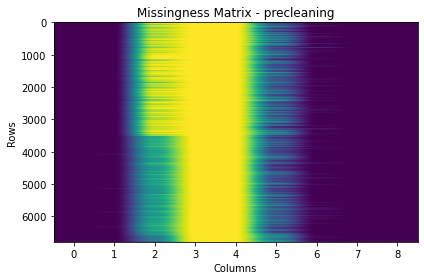

Dropping all-NaN numeric features for EDA: ['BASE_TAU', 'BASE_PTAU']
Dropping all-NaN categorical features for EDA: []
Shape after imputation: (6785, 7)
Remaining missing data after imputation (top):


,missing,percent


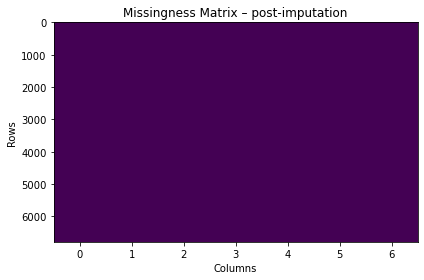

In [47]:
#'Missingness' matrix--a 2D view of missing data 
plt.figure()
miss = df_baseline[numeric_cols + categorical_cols].isnull().astype(int).values
plt.imshow(miss, aspect='auto')
plt.title("Missingness Matrix - precleaning")
plt.xlabel("Columns"); plt.ylabel("Rows")
plt.tight_layout(); plt.savefig(FIG_DIR / "missing_before_clean.png"); plt.show()

#Imputation for EDA
from sklearn.impute import SimpleImputer
num_imp = SimpleImputer(strategy="median")
cat_imp = SimpleImputer(strategy="most_frequent")

num_use = [c for c in numeric_cols if c in df_baseline.columns and df_baseline[c].notna().any()]
num_allnan = [c for c in numeric_cols if c in df_baseline.columns and c not in num_use]
print("Dropping all-NaN numeric features for EDA:", num_allnan)

X_num = num_imp.fit_transform(df_baseline[num_use]) if num_use else np.empty((len(df_baseline), 0))
df_imputed_eda = pd.DataFrame(X_num, columns=num_use, index=df_baseline.index)

cat_use, cat_allnan = [], []
if categorical_cols:
    cat_use = [c for c in categorical_cols if c in df_baseline.columns and df_baseline[c].notna().any()]
    cat_allnan = [c for c in categorical_cols if c in df_baseline.columns and c not in cat_use]
    print("Dropping all-NaN categorical features for EDA:", cat_allnan)

    X_cat = cat_imp.fit_transform(df_baseline[cat_use]) if cat_use else np.empty((len(df_baseline),0))
    for i, col in enumerate(cat_use):
        df_imputed_eda[col] = X_cat[:, i]

print("Shape after imputation:", df_imputed_eda.shape)
print("Remaining missing data after imputation (top):")
display(missing_summary(df_imputed_eda).head(25))

cols_after = [c for c in (num_use + cat_use) if c in df_imputed_eda.columns]
plt.figure()
miss_after = df_imputed_eda[cols_after].isnull().astype(int).values
plt.imshow(miss_after, aspect='auto')
plt.title("Missingness Matrix – post-imputation")
plt.xlabel("Columns"); plt.ylabel("Rows")
plt.tight_layout(); plt.savefig(FIG_DIR / "missing_after_impute.png"); plt.show()

In [48]:
#Feature audit tables -> PNGs
audit_counts = pd.DataFrame({
    "Dropped (all-NaN)": [len(num_allnan), len(cat_allnan)],
    "Kept (used)": [len(num_use), len(cat_use)],
    "Total considered": [len(num_allnan) + len(num_use), len(cat_allnan) + len(cat_use)]
}, index=["Numeric features", "Categorical features"])

display(audit_counts)

def save_table_png(df: pd.DataFrame, path: Path, title: str = "", font_size=9):
    fig, ax = plt.subplots(figsize=(8, 0.5 + 0.4* (len(df) + 1)))
    ax.axis('off')
    tbl = ax.table(cellText=df.values, colLabels=df.columns,
                   rowLabels=df.index if df.index.name or (df.index.tolist() != list(range(len(df)))) else None,
                   loc='center', cellLoc='left')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    if title:
        ax.set_title(title, fontweight='bold', pad=12)
    fig.tight_layout()
    fig.savefig(path, dpi=200, bbox_inches='tight')
    plt.close(fig)

save_table_png(audit_counts.copy(), FIG_DIR / "table_a_feature_audit_counts.png",
               title="Table A. Feature Audit — Counts", font_size=10)

def _fmt_list(lst):
    if not lst: return "(none)"
    return "• " + "\n• ".join(lst)

audit_detail = pd.DataFrame({
    "Feature Set": ["Numeric (Dropped all-NaN)", "Categorical (Dropped all-NaN)",
                    "Numeric (Kept)", "Categorical (Kept)"],
    "Count": [len(num_allnan), len(cat_allnan), len(num_use), len(cat_use)],
    "Columns": [_fmt_list(num_allnan), _fmt_list(cat_allnan),
                _fmt_list(num_use), _fmt_list(cat_use)]
})

def wrap_bullets(text: str, width=40):
    if text == "(none)": return text
    lines = []
    for line in text.split("\n"):
        if line.startswith("• "):
            bullet = "• "
            import textwrap as tw
            wrapped = tw.wrap(line[2:], width=width) or [""]
            lines.extend([bullet + wrapped[0]] + ["  " + w for w in wrapped[1:]])
        else:
            import textwrap as tw
            lines.extend(tw.wrap(line, width=width) or [""])
    return "\n".join(lines)

audit_detail_png = audit_detail.copy()
audit_detail_png["Columns"] = audit_detail_png["Columns"].apply(lambda s: wrap_bullets(s, width=40))
save_table_png(audit_detail_png.set_index("Feature Set"),
               FIG_DIR / "table_b_feature_audit_detailed.png",
               title="Table B. Feature Audit — Detailed Lists", font_size=9)

print("Saved tables to:",
      FIG_DIR / "table_a_feature_audit_counts.png",
      "and",
      FIG_DIR / "table_b_feature_audit_detailed.png")

,Dropped (all-NaN),Kept (used),Total considered
Numeric features,2,5,7
Categorical features,0,2,2


Saved tables to: C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\table_a_feature_audit_counts.png and C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\table_b_feature_audit_detailed.png


Dropping all-NaN numeric features for EDA: ['BASE_TAU', 'BASE_PTAU']
Dropping all-NaN categorical features for EDA: []
Shape after imputation: (6785, 7)
Remaining missing data after imputation (top):


,missing,percent


NOTE: These expected columns are not present post-imputation (likely all-NaN or absent): ['BASE_PTAU', 'BASE_TAU']


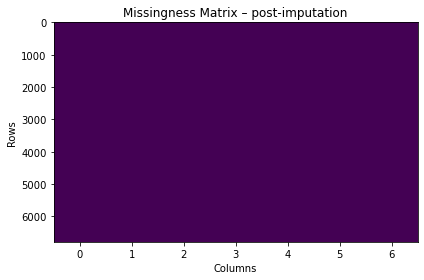

,Dropped (all-NaN),Kept (used),Total considered
Numeric features,2,5,7
Categorical features,0,2,2


,Feature Set,Count,Columns
0,Numeric (Dropped all-NaN),2,. BASE_TAU . BASE_PTAU
1,Categorical (Dropped all-NaN),0,(none)
2,Numeric (Kept),5,. BASE_AGE . BASE_APOE4 . BASE_AV45 . BASE_Hippocampus . BASE_ADAS13
3,Categorical (Kept),2,. BASE_SEX . BASE_DX


Saved tables to: C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\table_a_feature_audit_counts.png and C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\table_b_feature_audit_detailed.png


In [49]:
#EDA Revisted-Imputation
import textwrap

num_imp = SimpleImputer(strategy="median") #median is a better option than mean, as outliers may skew results
cat_imp = SimpleImputer(strategy="most_frequent") #may need to revisit this

#Splitting numeric into usable vs all-NaN (based on CURRENT df_baseline)
num_use = [c for c in numeric_cols if c in df_baseline.columns and df_baseline[c].notna().any()]
num_allnan = [c for c in numeric_cols if c in df_baseline.columns and c not in num_use]
print("Dropping all-NaN numeric features for EDA:", num_allnan)

#Imputing only usable numeric
X_num = num_imp.fit_transform(df_baseline[num_use]) if num_use else np.empty((len(df_baseline), 0))
df_imputed_eda = pd.DataFrame(X_num, columns=num_use, index=df_baseline.index)

#Categorical (same logic)
cat_use, cat_allnan = [], []
if categorical_cols:
    cat_use = [c for c in categorical_cols if c in df_baseline.columns and df_baseline[c].notna().any()]
    cat_allnan = [c for c in categorical_cols if c in df_baseline.columns and c not in cat_use]
    print("Dropping all-NaN categorical features for EDA:", cat_allnan)

    X_cat = cat_imp.fit_transform(df_baseline[cat_use]) if cat_use else np.empty((len(df_baseline),0))
    for i, col in enumerate(cat_use):
        df_imputed_eda[col] = X_cat[:, i]

#Diagnostics
print("Shape after imputation:", df_imputed_eda.shape)
print("Remaining missing data after imputation (top):")
display(missing_summary(df_imputed_eda).head(25))

#Build the column list that ACTUALLY exists now (to avoid KeyError)
cols_after = [c for c in (num_use + cat_use) if c in df_imputed_eda.columns]

#Warning if something expected is missing
expected = set(numeric_cols + categorical_cols)
present = set(df_imputed_eda.columns)
missing_now = sorted(list(expected - present))
if missing_now:
    print("NOTE: These expected columns are not present post-imputation (likely all-NaN or absent):", missing_now)

#Post-imputation "missingness" matrix
plt.figure()
miss_after = df_imputed_eda[cols_after].isnull().astype(int).values
plt.imshow(miss_after, aspect='auto')
plt.title("Missingness Matrix – post-imputation")
plt.xlabel("Columns"); plt.ylabel("Rows")
plt.tight_layout(); plt.savefig(FIG_DIR / "missing_after_impute.png"); plt.show()

#Create easy to read audit tables: summary + detailed and PNG exports

#Summary (counts only)
audit_counts = pd.DataFrame({
    "Dropped (all-NaN)": [len(num_allnan), len(cat_allnan)],
    "Kept (used)": [len(num_use), len(cat_use)],
    "Total considered": [len(num_allnan) + len(num_use), len(cat_allnan) + len(cat_use)]
}, index=["Numeric features", "Categorical features"])

styled_counts = (
    audit_counts.style
        .set_caption("Table A. Feature Audit — Counts")
        .format("{:,.0f}")
        .set_table_styles([
            {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold"), ("padding-bottom", "0.5rem")]},
            {"selector": "th", "props": [("background-color", "#f2f2f2"), ("font-weight", "bold")]}
        ])
)

display(styled_counts)

#Export a DataFrame to a PNG via matplotlib table
def save_table_png(df: pd.DataFrame, path: Path, title: str = "", col_widths=None, font_size=9):
    fig, ax = plt.subplots(figsize=(8, 0.5 + 0.4* (len(df) + 1)))  # dynamic height
    ax.axis('off')
    tbl = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index if df.index.name or (df.index.tolist() != list(range(len(df)))) else None,
        loc='center',
        cellLoc='left',
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    if col_widths:
        for i, w in enumerate(col_widths):
            tbl.auto_set_column_width(i)
    if title:
        ax.set_title(title, fontweight='bold', pad=12)
    fig.tight_layout()
    fig.savefig(path, dpi=200, bbox_inches='tight')
    plt.close(fig)

#Export the summary counts table
save_table_png(
    audit_counts.copy(),
    FIG_DIR / "table_a_feature_audit_counts.png",
    title="Table A. Feature Audit — Counts",
    font_size=10
)

#Detailed (names listed) – with wrapping and line breaks
def _fmt_list(lst):
    if not lst: return "(none)"
    return ". " + "\n. ".join(lst)

audit_detail = pd.DataFrame({
    "Feature Set": ["Numeric (Dropped all-NaN)", "Categorical (Dropped all-NaN)",
                    "Numeric (Kept)", "Categorical (Kept)"],
    "Count": [len(num_allnan), len(cat_allnan), len(num_use), len(cat_use)],
    "Columns": [_fmt_list(num_allnan), _fmt_list(cat_allnan),
                _fmt_list(num_use), _fmt_list(cat_use)]
})

#Display with wrapped text in notebook
styled_detail = (
    audit_detail.style
        .set_caption("Table B. Feature Audit — Detailed Lists")
        .format({"Count": "{:,.0f}"})
        .set_properties(subset=["Columns"], **{"white-space": "pre-wrap"})
        .set_table_styles([
            {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold"), ("padding-bottom", "0.5rem")]},
            {"selector": "th", "props": [("background-color", "#f2f2f2"), ("font-weight", "bold")]},
            {"selector": "td", "props": [("vertical-align", "top")]}
        ])
)
display(styled_detail)

#For PNG export, wrap the text to keep the image compact
def wrap_bullets(text: str, width=40):
    if text == "(none)": return text
    lines = []
    for line in text.split("\n"):
        if line.startswith(". "):
            bullet = ". "
            wrapped = textwrap.wrap(line[2:], width=width) or [""]
            lines.extend([bullet + wrapped[0]] + ["  " + w for w in wrapped[1:]])
        else:
            lines.extend(textwrap.wrap(line, width=width) or [""])
    return "\n".join(lines)

audit_detail_png = audit_detail.copy()
audit_detail_png["Columns"] = audit_detail_png["Columns"].apply(lambda s: wrap_bullets(s, width=40))

#Export the detailed table to PNG
save_table_png(
    audit_detail_png.set_index("Feature Set"),
    FIG_DIR / "table_b_feature_audit_detailed.png",
    title="Table B. Feature Audit — Detailed Lists",
    font_size=9
)

print("Saved tables to:",
      FIG_DIR / "table_a_feature_audit_counts.png",
      "and",
      FIG_DIR / "table_b_feature_audit_detailed.png")

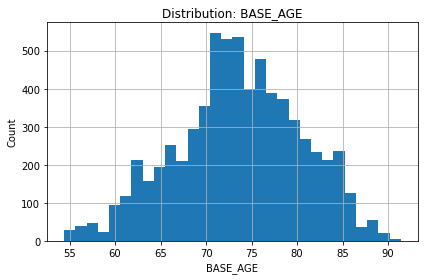

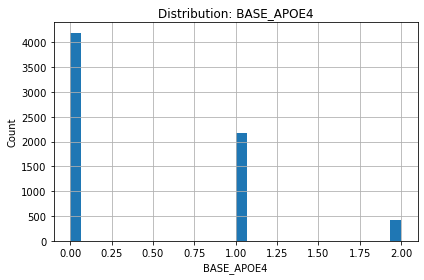

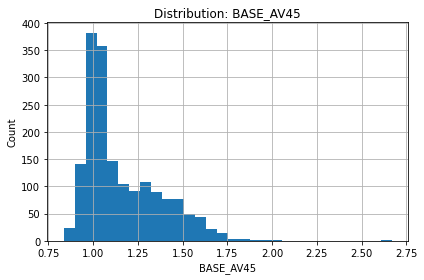

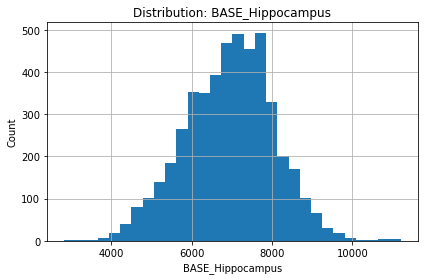

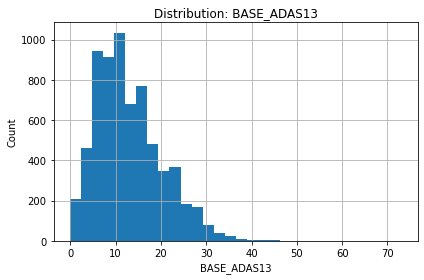

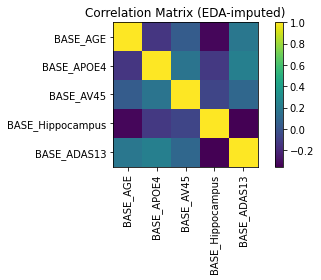

BASE_Hippocampus vs BASE_ADAS13: 0.355
BASE_AGE vs BASE_Hippocampus: 0.329
BASE_APOE4 vs BASE_ADAS13: 0.232
BASE_AGE vs BASE_ADAS13: 0.182
BASE_APOE4 vs BASE_AV45: 0.164
BASE_AGE vs BASE_APOE4: 0.141
BASE_APOE4 vs BASE_Hippocampus: 0.128
BASE_AV45 vs BASE_ADAS13: 0.096
BASE_AV45 vs BASE_Hippocampus: 0.074
BASE_AGE vs BASE_AV45: 0.039


In [50]:
#Distributions & correlations
for col in ["BASE_AGE","BASE_APOE4","BASE_AV45","BASE_Hippocampus","BASE_ADAS13"]:
    if col in df_baseline.columns:
        plt.figure()
        df_baseline[col].hist(bins=30)
        plt.title(f"Distribution: {col}")
        plt.xlabel(col); plt.ylabel("Count")
        plt.tight_layout(); plt.savefig(FIG_DIR / f"hist_{col}.png"); plt.show()

num_exist = [c for c in numeric_cols if c in df_imputed_eda.columns]
corr = df_imputed_eda[num_exist].corr()
plt.figure()
ax = plt.gca()
im = ax.imshow(corr, interpolation="nearest")
ax.set_xticks(range(len(num_exist))); ax.set_xticklabels(num_exist, rotation=90)
ax.set_yticks(range(len(num_exist))); ax.set_yticklabels(num_exist)
plt.title("Correlation Matrix (EDA-imputed)")
plt.colorbar(im)
plt.tight_layout(); plt.savefig(FIG_DIR / "corr_numeric_eda.png"); plt.show()

pairs = []
for i in range(len(num_exist)):
    for j in range(i+1, len(num_exist)):
        pairs.append((num_exist[i], num_exist[j], abs(corr.iloc[i,j])))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:10]
for a,b,v in pairs_sorted:
    print(f"{a} vs {b}: {v:.3f}")

Target value counts:
0    6486
1     299 

Resolved columns:
  AV45 -> BASE_AV45
  TAU -> BASE_TAU
  PTAU -> BASE_PTAU
  Hippocampus -> BASE_Hippocampus
  ADAS13 -> BASE_ADAS13

BASE_AV45: n0=1695, n1=43


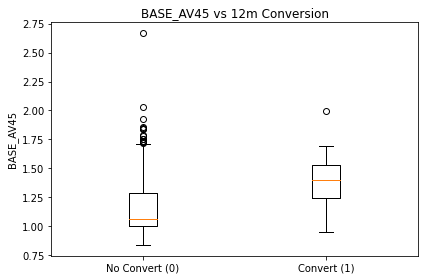

  Saved: C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\box_BASE_AV45_bylabel.png

BASE_TAU: n0=0, n1=0
  Skipping BASE_TAU: need both classes with data.

BASE_PTAU: n0=0, n1=0
  Skipping BASE_PTAU: need both classes with data.

BASE_Hippocampus: n0=4553, n1=228


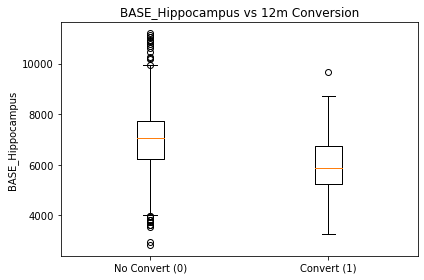

  Saved: C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\box_BASE_Hippocampus_bylabel.png

BASE_ADAS13: n0=6426, n1=298


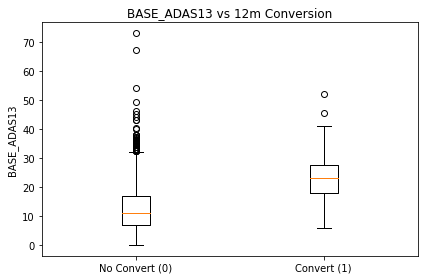

  Saved: C:\Users\jdaly\OneDrive\Desktop\ISM645-Pred Analytics\TADPOLE\figures\box_BASE_ADAS13_bylabel.png



In [51]:
#Boxplots vs. label
import re
target = "convert_within_12m"
y = df_baseline[target].astype("Int64")

print("Target value counts:")
print(y.value_counts(dropna=True).to_string(), "\n")

want_patterns = {
    "AV45": r"(^|_)av45($|_)",
    "TAU": r"(^|_)tau($|_)|upennbiomk",
    "PTAU": r"ptau",
    "Hippocampus": r"hippocampus",
    "ADAS13": r"adas13"
}

resolved_cols = {}
lower_cols = {c: c.lower() for c in df_baseline.columns}
for key, pat in want_patterns.items():
    patc = re.compile(pat, re.IGNORECASE)
    match = next((orig for orig, low in lower_cols.items() if patc.search(low)), None)
    if match:
        resolved_cols[key] = match

print("Resolved columns:")
for k, v in resolved_cols.items():
    print(f"  {k} -> {v}")
print()

if set(y.dropna().unique()) >= {0,1} and len(resolved_cols) > 0:
    y2 = y.dropna().astype(int)
    for key, col in resolved_cols.items():
        s = df_baseline[col].reindex(y2.index).dropna()
        yy = y2.reindex(s.index)
        grp0 = s[yy == 0].values
        grp1 = s[yy == 1].values
        print(f"{col}: n0={len(grp0)}, n1={len(grp1)}")
        if len(grp0) == 0 or len(grp1) == 0:
            print(f"  Skipping {col}: need both classes with data.\n")
            continue
        plt.figure()
        plt.boxplot([grp0, grp1], labels=["No Convert (0)", "Convert (1)"])
        plt.title(f"{col} vs 12m Conversion")
        plt.ylabel(col)
        plt.tight_layout()
        outpath = FIG_DIR / f"box_{col}_bylabel.png"
        plt.savefig(outpath, dpi=150)
        plt.show()
        plt.close()
        print(f"  Saved: {outpath}\n")
else:
    if not set(y.dropna().unique()) >= {0,1}:
        print("No plot: target has fewer than two classes after labeling.")
    if len(resolved_cols) == 0:
        print("No plot: none of the requested biomarker columns were found.")

,feature,outliers
4,BASE_ADAS13,68
0,BASE_AGE,29
3,BASE_Hippocampus,25
2,BASE_AV45,14
1,BASE_APOE4,0


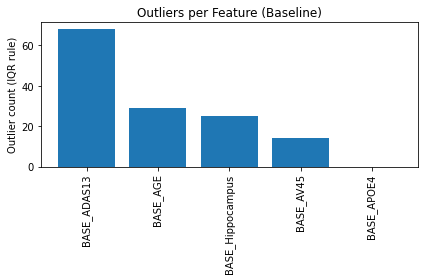

In [52]:
#Outlier audit via Interquartile Range (IQR)
def iqr_outlier_mask(s):
    q1, q3 = np.nanpercentile(s, 25), np.nanpercentile(s, 75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (s < low) | (s > high)

outlier_counts = {}
for col in [c for c in num_exist if c in df_baseline.columns]:
    s = df_baseline[col]
    mask = iqr_outlier_mask(s.values.astype(float))
    outlier_counts[col] = int(np.nansum(mask))

outlier_df = pd.DataFrame({"feature": list(outlier_counts.keys()), "outliers": list(outlier_counts.values())}).sort_values("outliers", ascending=False)
display(outlier_df.head(10))

plt.figure()
plt.bar(outlier_df["feature"], outlier_df["outliers"])
plt.xticks(rotation=90)
plt.ylabel("Outlier count (IQR rule)")
plt.title("Outliers per Feature (Baseline)")
plt.tight_layout(); plt.savefig(FIG_DIR / "outliers_per_feature.png"); plt.show()

Pre-split label counts: {0: 6486, 1: 299}
Post-split: {'train': {0: 4864, 1: 224}, 'test': {0: 1622, 1: 75}}


,AUROC,PR_AUC,F1,Accuracy,Brier
logreg,0.859523,0.19660,0.229572,0.766647,0.154112
rf,0.831204,0.22308,0.119048,0.956394,0.039286


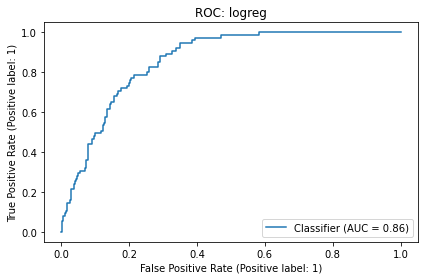

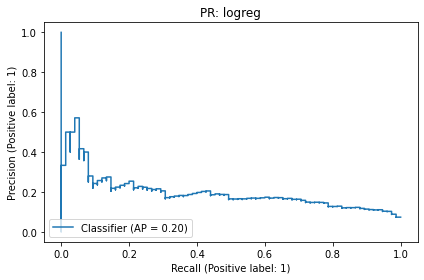

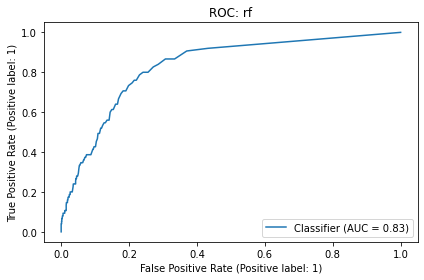

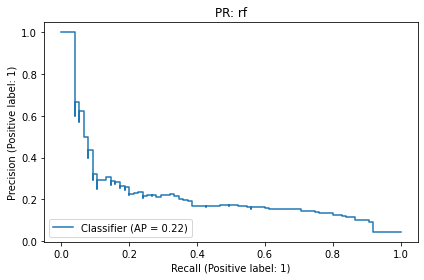

In [53]:
#Modeling, Results, and Evaluation (v4)

from collections import OrderedDict

target = "convert_within_12m"
categorical_cols = [c for c in ["BASE_SEX", "BASE_DX"] if c in df_baseline.columns]
numeric_cols = [c for c in df_baseline.columns if c.startswith("BASE_") and c not in categorical_cols
                and c not in ["BASE_EXAMDATE", target]]

X = df_baseline[categorical_cols + numeric_cols].copy()
y = df_baseline[target].astype(int)

print("Pre-split label counts:", y.value_counts().to_dict())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RNG_SEED, stratify=y
)
print("Post-split:", {"train": y_train.value_counts().to_dict(), "test": y_test.value_counts().to_dict()})
assert y_train.nunique() == 2 and y_test.nunique() == 2, "Split lost a class; check label balance."

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))  # 'sparse=False' for sklearn<=1.1
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

models = OrderedDict()
models["logreg"] = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear"))
])
models["rf"] = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=RNG_SEED, class_weight="balanced_subsample"))
])

fitted, metrics = {}, {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)
    metrics[name] = {
        "AUROC": roc_auc_score(y_test, proba),
        "PR_AUC": average_precision_score(y_test, proba),
        "F1": f1_score(y_test, pred, zero_division=0),
        "Accuracy": accuracy_score(y_test, pred),
        "Brier": brier_score_loss(y_test, proba)
    }

metrics_df = pd.DataFrame(metrics).T.sort_values("AUROC", ascending=False)
display(metrics_df)

for name, pipe in fitted.items():
    proba = pipe.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f"ROC: {name}")
    plt.tight_layout(); plt.savefig(FIG_DIR / f"roc_{name}.png", dpi=150); plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, proba)
    plt.title(f"PR: {name}")
    plt.tight_layout(); plt.savefig(FIG_DIR / f"pr_{name}.png", dpi=150); plt.show()